In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Tratamento dos dados

In [2]:
df = pd.read_csv("data/results/time_data.csv", sep=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         12960 non-null  object 
 1   812A         12960 non-null  float64
 2   833A         12960 non-null  float64
 3   812A_tweets  12960 non-null  float64
 4   833A_tweets  12960 non-null  float64
 5   812A_flood   12960 non-null  int64  
 6   833A_flood   12960 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 708.9+ KB


In [4]:
df["time"] = pd.to_datetime(df["time"])

C:\Users\Jefferson\AppData\Local\Temp\ipykernel_5568\2530938752.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [5]:
df = df.drop(["812A_tweets", "833A_tweets"], axis=1)

In [6]:
def plot_rain_gauge(df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    columns = ["812A", "833A"]

    for i, col in enumerate(columns):
        axs[i].plot(df["time"], df[col], label=col, color=f"C{i}")
        axs[i].set_title(f"Série Temporal: {col}")
        axs[i].set_ylabel("Valor")
        axs[i].legend()

    axs[-1].set_xlabel("Data")

    plt.tight_layout()
    plt.show()

In [7]:
# plot_rain_gauge(df)

In [8]:
df['833A'] = df['833A'].apply(lambda x: 2.5 if x > 2.5 else x)

In [9]:
df["flood"] = 0

In [10]:
df.loc[((df["812A_flood"] == 1) | (df["833A_flood"] == 1)), "flood"] = 1

In [11]:
X = df[["812A", "833A"]]
y = df["flood"]

# Setup

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
class FloodDataset(Dataset):
    def __init__(self, data, sequence_length, predict_ahead):
        self.data = data
        self.sequence_length = sequence_length
        self.predict_ahead = predict_ahead

    def __len__(self):
        # Ensure length is non-negative
        return max(0, len(self.data) - self.sequence_length - self.predict_ahead + 1)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self)}")
        
        # Input sequence: rain_gauge_1 and rain_gauge_2 for the past `sequence_length` time steps
        x = self.data[idx:idx+self.sequence_length, :-1]
        
        y = self.data[idx+self.sequence_length, -1]
        
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return x, y

In [33]:
class FloodLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FloodLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


In [34]:
def collate_fn(batch):
    # Separate inputs and labels
    inputs, labels = zip(*batch)
    
    # Pad the input sequences to the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    
    # Stack the labels into a single tensor
    labels = torch.stack(labels)
    
    return inputs_padded, labels

In [66]:
def print_class_distribution(data, dataset_name):
    class_counts = np.unique(data[:, -1], return_counts=True)
    print(f"Class distribution in {dataset_name}:")
    for class_label, count in zip(class_counts[0], class_counts[1]):
        print(f"Class {int(class_label)}: {count} examples")

In [69]:
data = df[["812A", "833A", "flood"]].values

sequence_length = 6 
predict_ahead = 1

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print_class_distribution(train_data, "training data")

Class distribution in training data:
Class 0: 9852 examples
Class 1: 516 examples


## Oversample

In [77]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(data):
    # Separate minority and majority classes
    minority_class = data[data[:, -1] == 1]
    majority_class = data[data[:, -1] == 0]
    
    # Oversample minority class
    oversample_factor = len(majority_class) // len(minority_class)
    oversampled_minority = np.repeat(minority_class, repeats=oversample_factor, axis=0)
    
    # Combine the datasets
    balanced_data = np.vstack([majority_class, oversampled_minority])
    
    # Shuffle the dataset
    np.random.shuffle(balanced_data)
    
    return balanced_data

def oversample_minority_class_smote(data):
    # Separate features (X) and labels (y)
    X = data[:, :-1]  # All columns except the last one
    y = data[:, -1]   # Last column (labels)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Combine the resampled features and labels
    balanced_data = np.hstack([X_resampled, y_resampled.reshape(-1, 1)])

    return balanced_data

In [93]:
train_data_oversampled = oversample_minority_class(train_data)

print_class_distribution(train_data_oversampled, "oversampled training data")

Class distribution in oversampled training data:
Class 0: 9852 examples
Class 1: 9804 examples


In [94]:
print("Training data shape:", train_data_oversampled.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data_oversampled, sequence_length, predict_ahead)
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (19656, 3)
Test data shape: (2592, 3)
Number of training samples: 19650
Number of testing samples: 2586


In [95]:
input_size = 2  # rain_gauge_1 and rain_gauge_2
hidden_size = 64
num_layers = 2
output_size = 1  # flood_boolean (binary)

model = FloodLSTM(input_size, hidden_size, num_layers, output_size)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

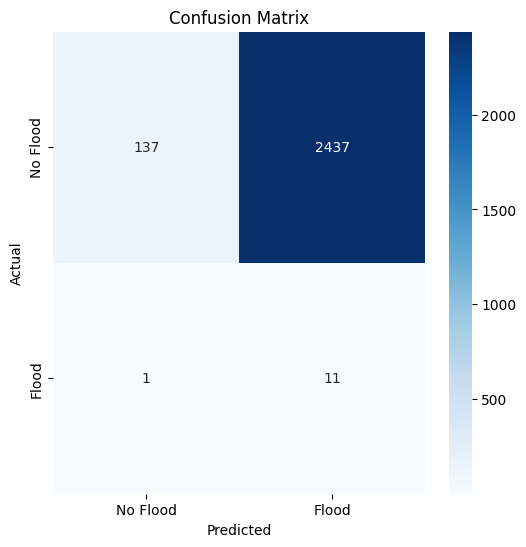


Classification Report:
               precision    recall  f1-score   support

    No Flood       0.99      0.05      0.10      2574
       Flood       0.00      0.92      0.01        12

    accuracy                           0.06      2586
   macro avg       0.50      0.48      0.05      2586
weighted avg       0.99      0.06      0.10      2586



In [96]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.squeeze().cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(all_labels, all_predictions, target_names=["No Flood", "Flood"])
print("\nClassification Report:\n", class_report)

## Treinamento com pesos nas classes

Ao invés de utilizar oversampling, esse teste adiciona peso as classes durante o treinamento do modelo.

Oversampling gerou resultados melhores, porém, é um método arriscado quando lidamos com séries temporais que possuem dados contínuos.

In [49]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_dataset = FloodDataset(train_data, sequence_length, predict_ahead)
test_dataset = FloodDataset(test_data, sequence_length, predict_ahead)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Training data shape: (10368, 3)
Test data shape: (2592, 3)
Number of training samples: 10362
Number of testing samples: 2586


In [50]:
input_size = 2  # rain_gauge_1 and rain_gauge_2
hidden_size = 64
num_layers = 2
output_size = 1  # flood_boolean (binary)

model = FloodLSTM(input_size, hidden_size, num_layers, output_size)

train_df = df[:train_size]

num_negatives = len(train_df[train_df["flood"] == 0])
num_positives = len(train_df[train_df["flood"] == 1])

pos_weight = torch.tensor([num_negatives/num_positives])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

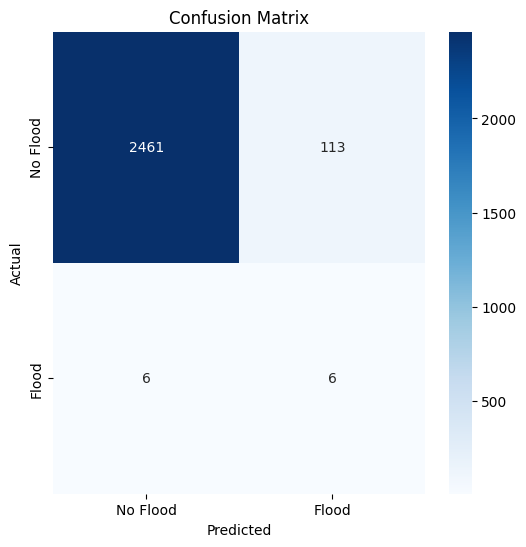


Classification Report:
               precision    recall  f1-score   support

    No Flood       1.00      0.96      0.98      2574
       Flood       0.05      0.50      0.09        12

    accuracy                           0.95      2586
   macro avg       0.52      0.73      0.53      2586
weighted avg       0.99      0.95      0.97      2586



In [51]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.squeeze().cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(all_labels, all_predictions, target_names=["No Flood", "Flood"])
print("\nClassification Report:\n", class_report)